# Model Comparison & Evaluation

All results are generated from saved checkpoints and metrics.
No retraining is performed.

**UNet Loss vs Epoch Graph**

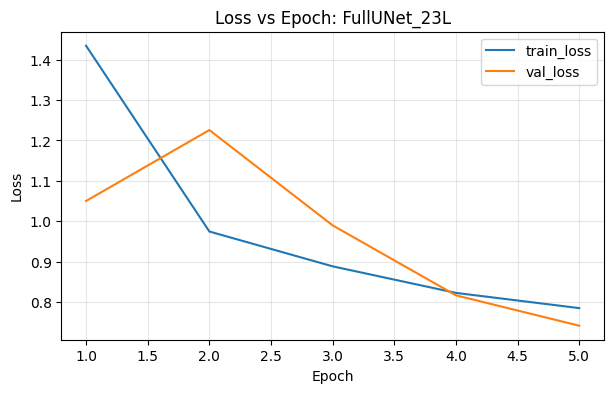

Best epoch: 5 | Best val_f1_macro: 0.7974153757095337


In [ ]:
RESULTS_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/model_results")
MODEL_NAME = "FullUNet_23L"
METRICS_JSON = RESULTS_DIR / f"{MODEL_NAME}_best_metrics.json"

assert METRICS_JSON.exists(), f"Missing metrics JSON: {METRICS_JSON}"

with open(METRICS_JSON, "r") as f:
    data = json.load(f)

history = data["history"]
epochs = [h["epoch"] for h in history]
train_loss = [h["train_loss"] for h in history]
val_loss   = [h["val_loss"] for h in history]

plt.figure(figsize=(7,4))
plt.plot(epochs, train_loss, label="train_loss")
plt.plot(epochs, val_loss, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss vs Epoch: {MODEL_NAME}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Best epoch:", data["best"]["epoch"], "| Best val_f1_macro:", data["best"]["val_f1_macro"])


**Locked Visuals for Analysis of Models**

/tmp/ipython-input-3330867802.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


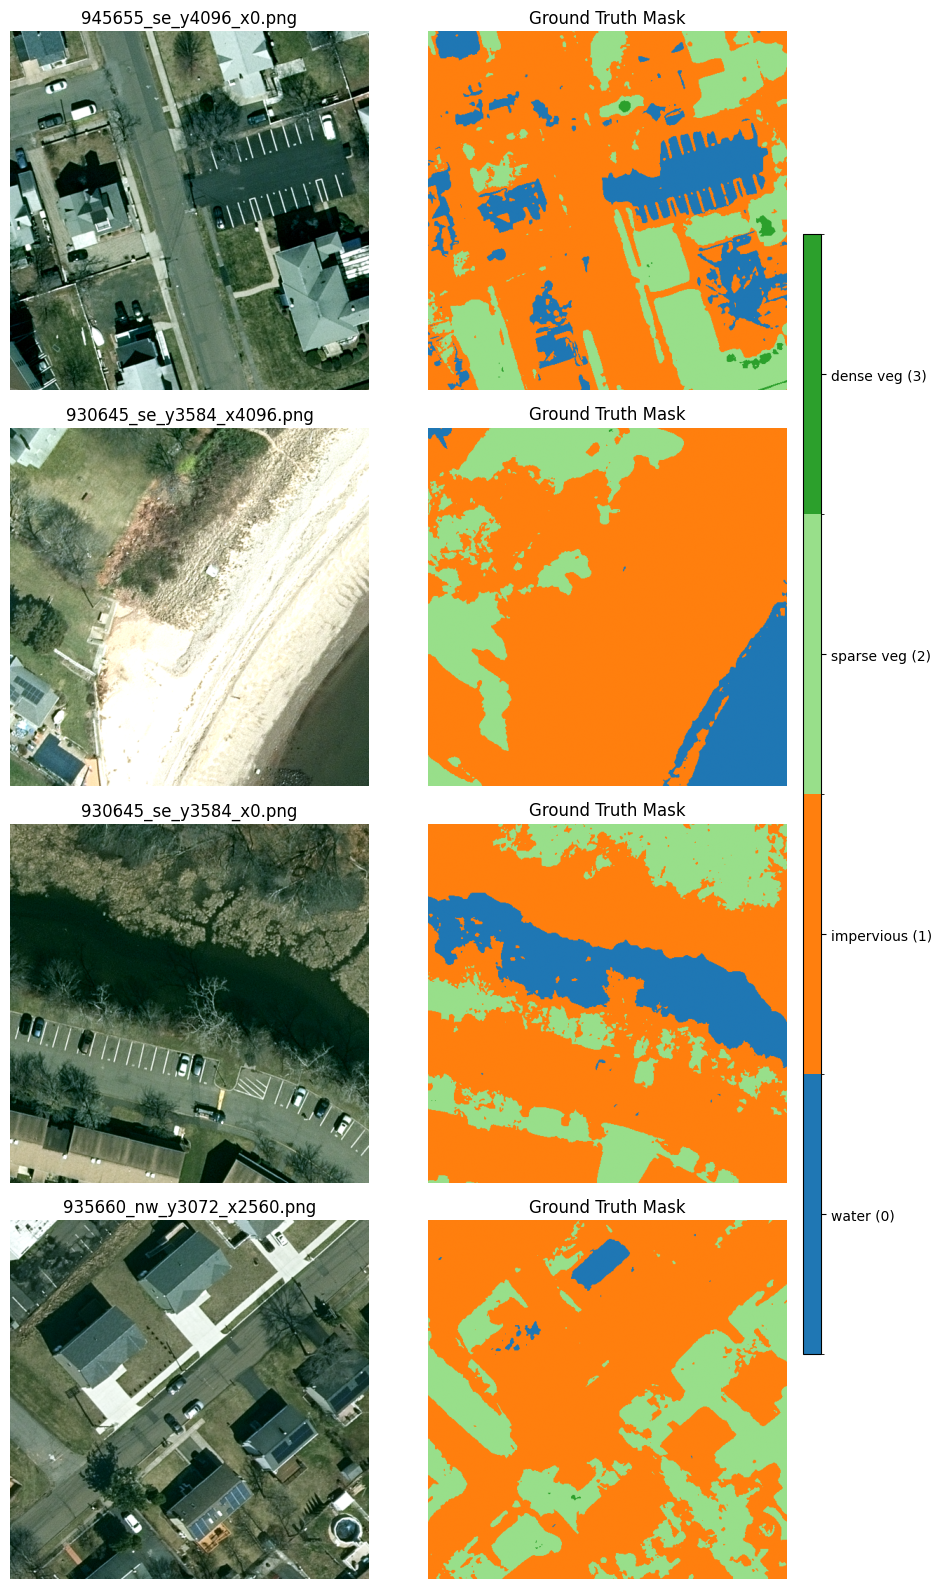

In [ ]:
TILES_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset_tiles_512")
IMG_DIR = TILES_BASE / "images"
MSK_DIR = TILES_BASE / "masks"

# Locked tiles
FIXED_TILES = [
    "945655_se_y4096_x0.png",
    "930645_se_y3584_x4096.png",
    "930645_se_y3584_x0.png",
    "935660_nw_y3072_x2560.png",
]

# Class setup
class_names  = ["water (0)", "impervious (1)", "sparse veg (2)", "dense veg (3)"]
class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

n = len(FIXED_TILES)
fig, axes = plt.subplots(n, 2, figsize=(9, 4 * n))

for i, fname in enumerate(FIXED_TILES):
    img_fp = IMG_DIR / fname
    msk_fp = MSK_DIR / f"{Path(fname).stem}_mask.png"

    rgb = np.array(Image.open(img_fp).convert("RGB"))
    mask = np.array(Image.open(msk_fp))
    if mask.ndim == 3:
        mask = mask[..., 0]

    # RGB
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(fname)
    axes[i, 0].axis("off")

    # Mask
    im = axes[i, 1].imshow(mask, cmap=cmap_mask, norm=norm_mask)
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis("off")

#Colorbar
cax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
cbar = fig.colorbar(
    im,
    cax=cax,
    ticks=[0, 1, 2, 3]
)
cbar.set_ticklabels([
    "water (0)",
    "impervious (1)",
    "sparse veg (2)",
    "dense veg (3)"
])
plt.tight_layout()
plt.show()

**UNet Model RGB vs Ground Truth vs Prediction Visualization**

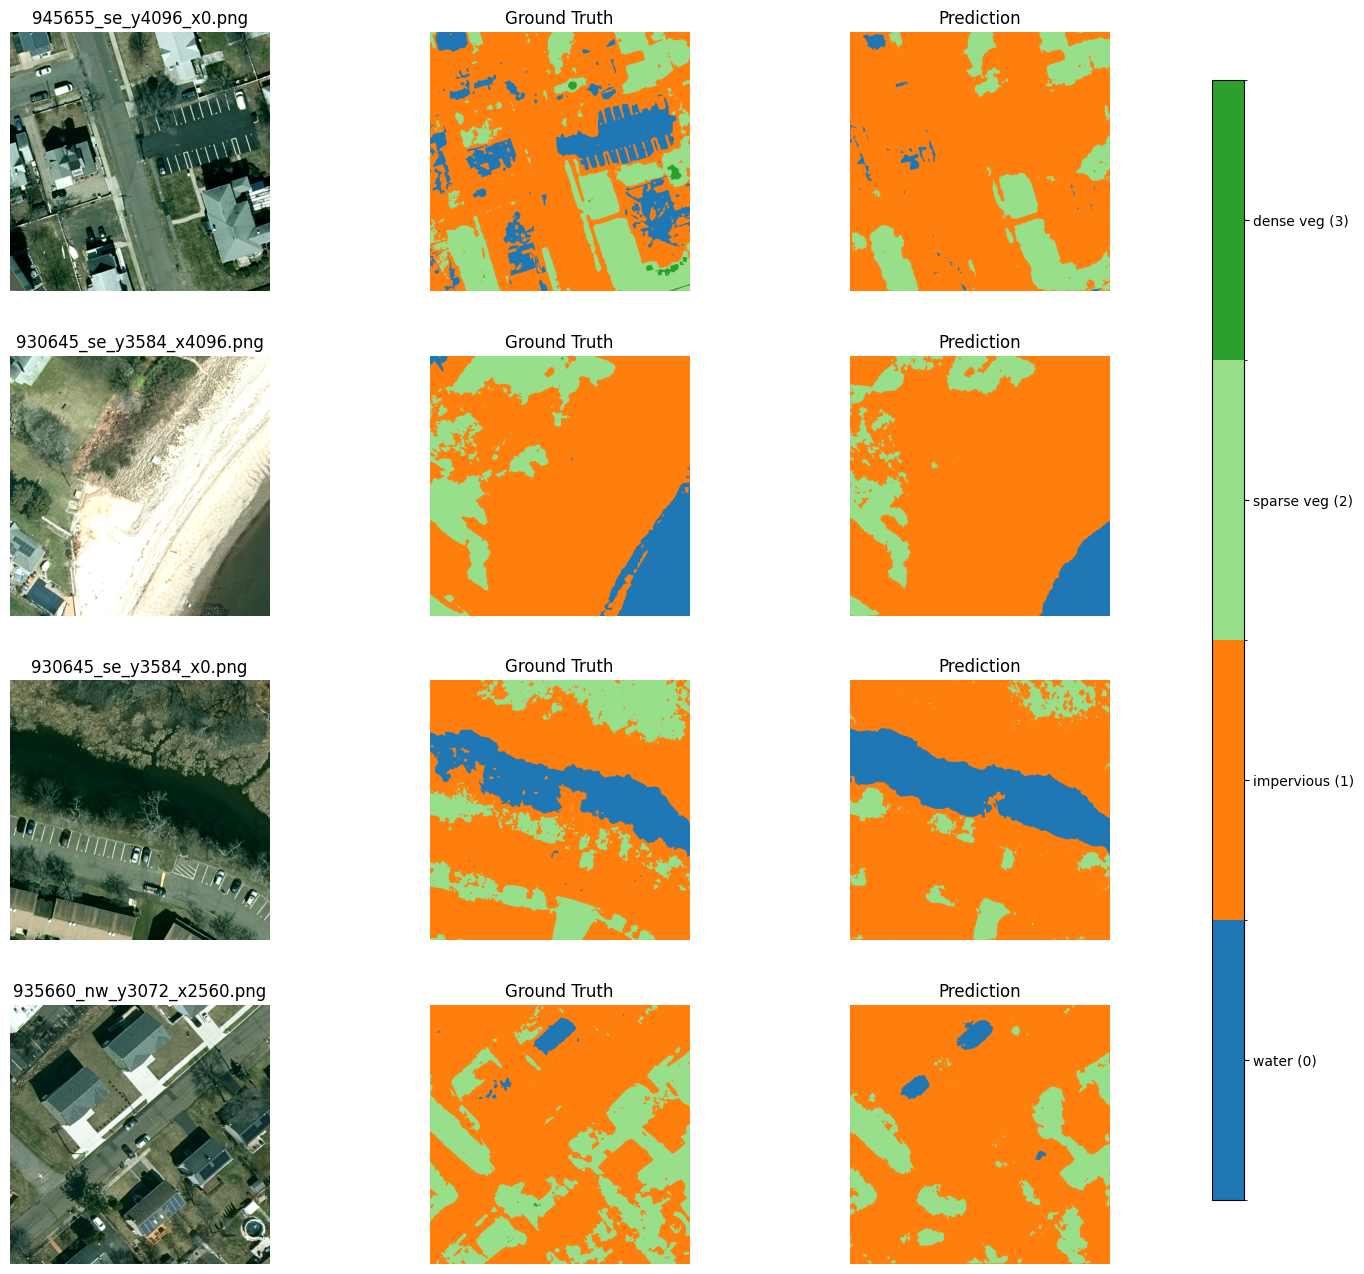

In [ ]:
# --- Paths ---
TILES_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset_tiles_512")
IMG_OUT = TILES_BASE / "images"
MSK_OUT = TILES_BASE / "masks"

# --- Locked comparison tiles ---
FIXED_TILES = [
    "945655_se_y4096_x0.png",
    "930645_se_y3584_x4096.png",
    "930645_se_y3584_x0.png",
    "935660_nw_y3072_x2560.png",
]

# --- Load BEST checkpoint for this model ---
CKPT_PATH = Path("/content/drive/MyDrive/ResearchProject (1)/model_results/FullUNet_23L_best.pt")

model = model_unet
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.to(DEVICE)
model.eval()

# --- Mask colormap ---
class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap_mask.N)

def load_rgb_tile(img_fp: Path):
    """Returns (H,W,3) uint8 and (1,3,H,W) float32 tensor in [0,1]."""
    rgb_u8 = np.array(Image.open(img_fp).convert("RGB"), dtype=np.uint8)
    x = torch.from_numpy(rgb_u8).permute(2, 0, 1).float() / 255.0  # (3,H,W)
    x = x.unsqueeze(0)  # (1,3,H,W)
    return rgb_u8, x

def load_mask_tile(msk_fp: Path):
    """Returns (H,W) uint8 labels 0..3."""
    return np.array(Image.open(msk_fp), dtype=np.uint8)

@torch.no_grad()
def predict_tile(model, x):
    """x: (1,3,H,W) -> pred: (H,W) uint8"""
    x = x.to(DEVICE, non_blocking=True)
    logits = model(x)
    # Some segmentation models return dict with "out"
    if isinstance(logits, dict):
        logits = logits["out"]
    pred = torch.argmax(logits, dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)
    return pred

# --- Plot: RGB | GT | Pred ---
rows = len(FIXED_TILES)
fig, axs = plt.subplots(rows, 3, figsize=(16, 4 * rows))

for i, name in enumerate(FIXED_TILES):
    img_fp = IMG_OUT / name
    msk_fp = MSK_OUT / f"{Path(name).stem}_mask.png"

    rgb_u8, x = load_rgb_tile(img_fp)
    gt = load_mask_tile(msk_fp)
    pred = predict_tile(model, x)

    axs[i, 0].imshow(rgb_u8)
    axs[i, 0].set_title(name)
    axs[i, 0].axis("off")

    im_gt = axs[i, 1].imshow(gt, cmap=cmap_mask, norm=norm_mask)
    axs[i, 1].set_title("Ground Truth")
    axs[i, 1].axis("off")

    im_pred = axs[i, 2].imshow(pred, cmap=cmap_mask, norm=norm_mask)
    axs[i, 2].set_title("Prediction")
    axs[i, 2].axis("off")

# Leave room on right for colorbar
fig.subplots_adjust(right=0.90, wspace=0.05, hspace=0.25)

# Colorbar axis (outside plots)
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im_pred, cax=cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(["water (0)", "impervious (1)", "sparse veg (2)", "dense veg (3)"])

plt.show()

**DeepLabV3-ResNet50 Loss vs Epoch Graph**

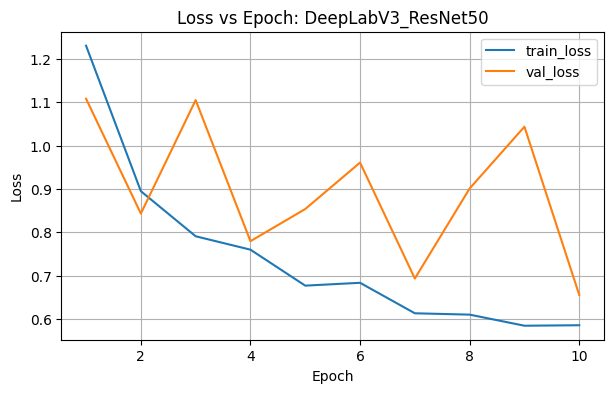

Best epoch: 7 | Best val_f1_macro: 0.810496985912323


In [ ]:
def plot_loss(history, title="Loss vs Epoch"):
    epochs = [row["epoch"] for row in history]
    train_loss = [row["train_loss"] for row in history]
    val_loss = [row["val_loss"] for row in history]

    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_loss, label="train_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(hist_deeplab, title="Loss vs Epoch: DeepLabV3_ResNet50")
print(f"Best epoch: {best_deeplab['epoch']} | Best val_f1_macro: {best_deeplab['val_f1_macro']}")

**DeepLabV3-ResNet50 Model RGB vs Ground Truth vs Prediction Visualization**

Loading checkpoint: /content/drive/MyDrive/ResearchProject (1)/model_results/DeepLabV3_ResNet50_best.pt


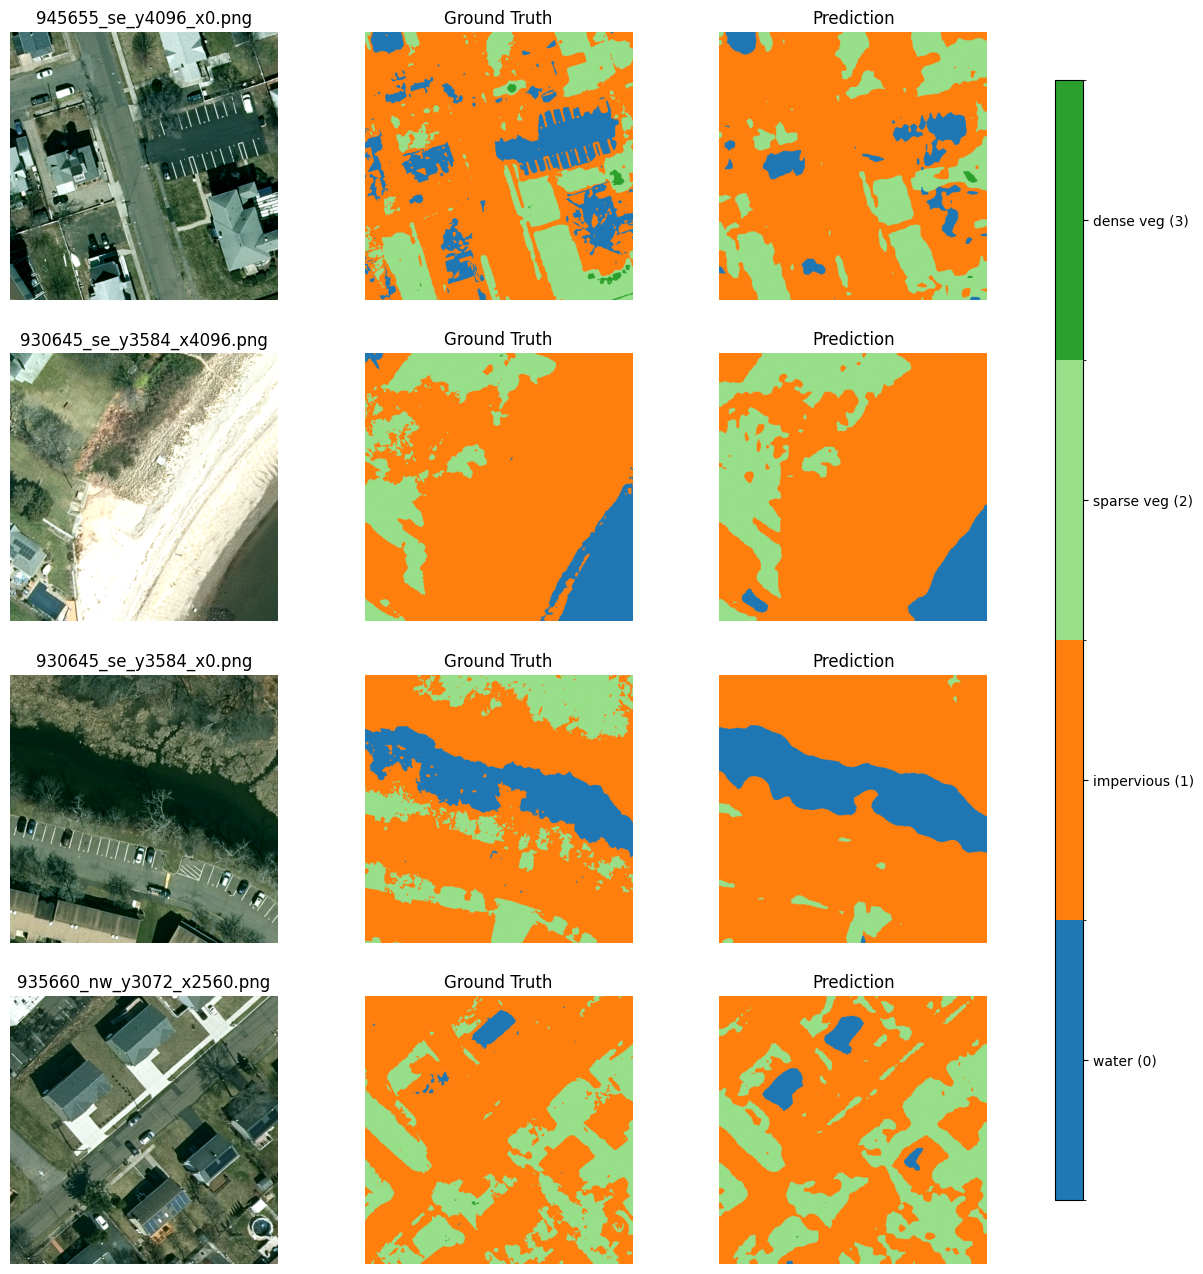

In [ ]:
# ---- paths ----
TILES_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset_tiles_512")
IMG_DIR = TILES_BASE / "images"
MSK_DIR = TILES_BASE / "masks"

# ---- locked tiles ----
FIXED_TILES = [
    "945655_se_y4096_x0.png",
    "930645_se_y3584_x4096.png",
    "930645_se_y3584_x0.png",
    "935660_nw_y3072_x2560.png",
]

# ---- load best checkpoint weights into the SAME model object ----
ckpt_path = Path(best_deeplab["path_ckpt"])
print("Loading checkpoint:", ckpt_path)
model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

# ---- colormap ----
# 0 water, 1 impervious, 2 sparse veg, 3 dense veg
class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# ---- plotting ----
fig, axes = plt.subplots(len(FIXED_TILES), 3, figsize=(14, 4*len(FIXED_TILES)))

for i, fname in enumerate(FIXED_TILES):
    img_fp = IMG_DIR / fname
    msk_fp = MSK_DIR / f"{Path(fname).stem}_mask.png"

    assert img_fp.exists(), f"Missing image: {img_fp}"
    assert msk_fp.exists(), f"Missing mask: {msk_fp}"

    # load RGB (uint8 H,W,3)
    rgb = np.array(Image.open(img_fp).convert("RGB"), dtype=np.uint8)

    # load GT mask (uint8 H,W)
    gt = np.array(Image.open(msk_fp), dtype=np.uint8)
    if gt.ndim == 3:
        gt = gt[:, :, 0].astype(np.uint8)

    # model input: float32 (1,3,H,W) in [0,1]
    x = torch.from_numpy(rgb).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    x = x.to(DEVICE)

    with torch.no_grad():
        out = model(x)
        if isinstance(out, dict):
            out = out["out"]
        pred = torch.argmax(out, dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)

    # RGB
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(fname)
    axes[i, 0].axis("off")

    # GT
    axes[i, 1].imshow(gt, cmap=cmap_mask, norm=norm_mask)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    # Pred
    im = axes[i, 2].imshow(pred, cmap=cmap_mask, norm=norm_mask)
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

# single colorbar on the far right (not on top of images)
fig.subplots_adjust(right=0.88, wspace=0.02)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.70])
cbar = fig.colorbar(im, cax=cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(["water (0)", "impervious (1)", "sparse veg (2)", "dense veg (3)"])

plt.show()


**U-Net + SCSE (ResNet-34 encoder) Model Loss vs Epoch Graph**

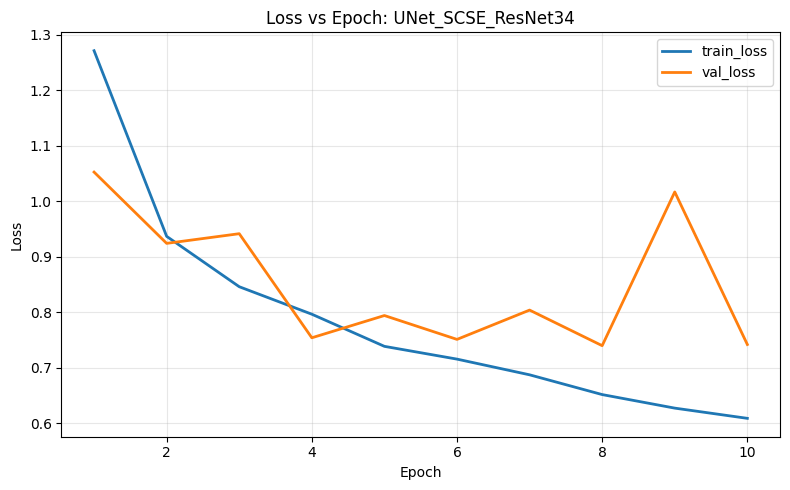

Best epoch: 10 | Best val_f1_macro: 0.7885


In [ ]:
# === Load metrics ===
MODEL_NAME = "UNet_SCSE_ResNet34"
metrics_path = Path("/content/drive/MyDrive/ResearchProject (1)/model_results") / f"{MODEL_NAME}_best_metrics.json"

with open(metrics_path, "r") as f:
    data = json.load(f)

history = data["history"]

epochs = [h["epoch"] for h in history]
train_loss = [h["train_loss"] for h in history]
val_loss = [h["val_loss"] for h in history]

best_epoch = data["best"]["epoch"]
best_f1 = data["best"]["val_f1_macro"]

# === Plot ===
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="train_loss", linewidth=2)
plt.plot(epochs, val_loss, label="val_loss", linewidth=2)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Loss vs Epoch: {MODEL_NAME}")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best epoch: {best_epoch} | Best val_f1_macro: {best_f1:.4f}")


**U-Net + SCSE (ResNet-34 encoder) Model RGB vs Ground Truth vs Prediction Visualization**

Device: cuda
Loading checkpoint: /content/drive/MyDrive/ResearchProject (1)/model_results/UNet_SCSE_ResNet34_best.pt


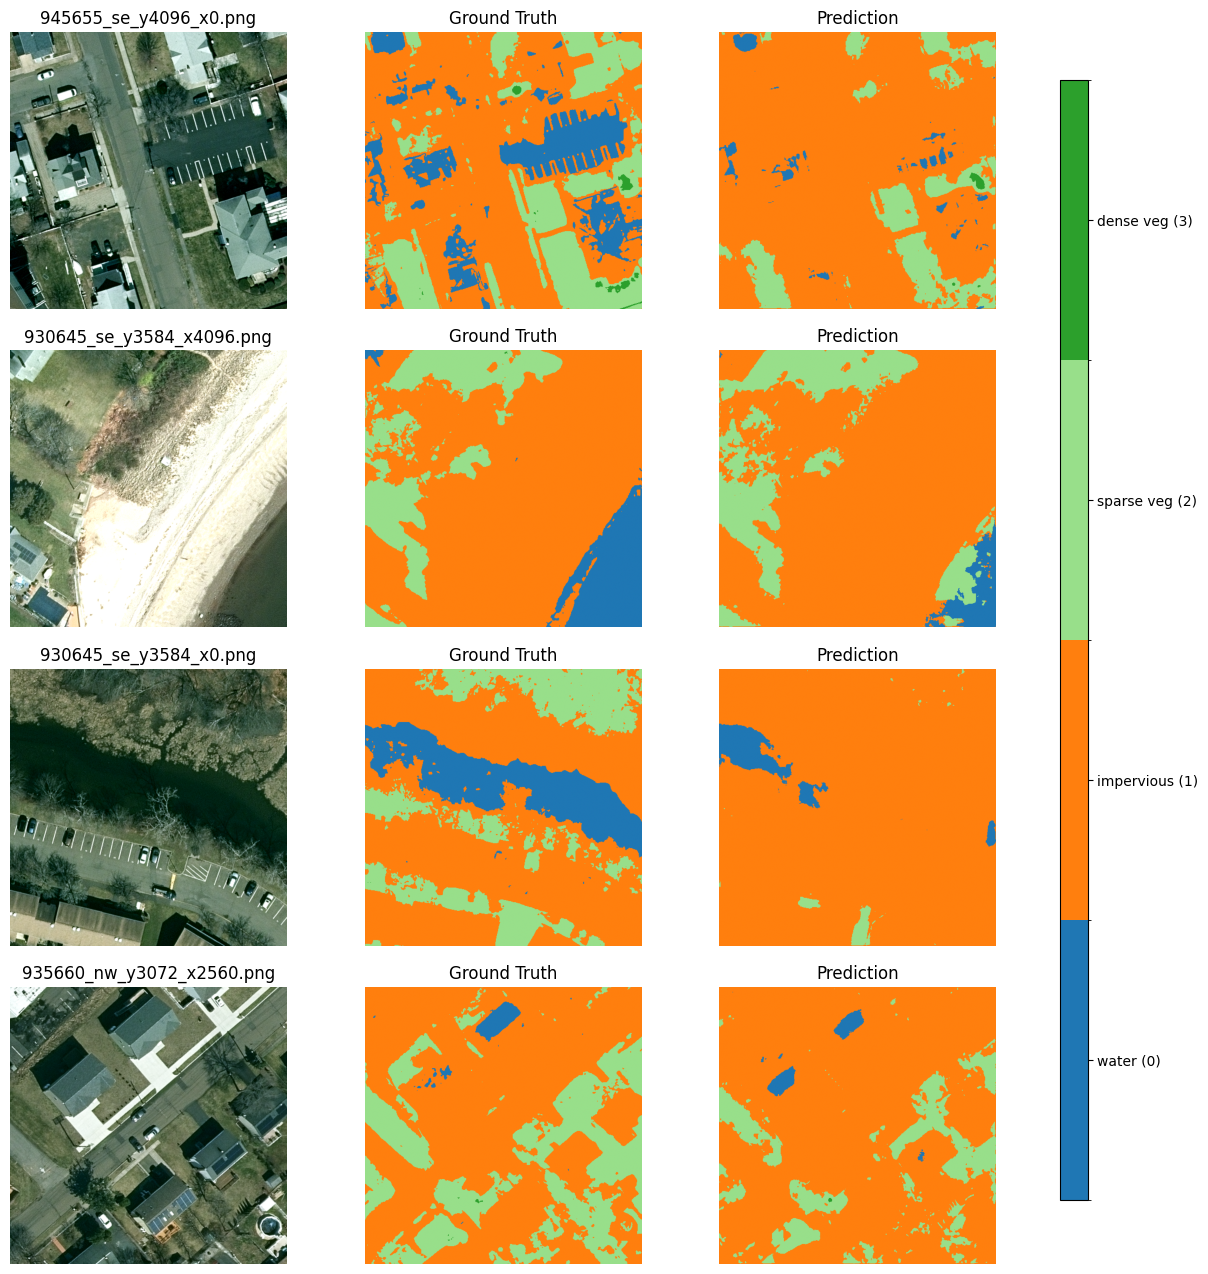

In [ ]:
# --- paths ---
TILES_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset_tiles_512")
IMG_DIR = TILES_BASE / "images"
MSK_DIR = TILES_BASE / "masks"

# --- locked tiles ---
FIXED_TILES = [
    "945655_se_y4096_x0.png",
    "930645_se_y3584_x4096.png",
    "930645_se_y3584_x0.png",
    "935660_nw_y3072_x2560.png",
]

# --- device ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

MODEL_NAME = "UNet_SCSE_ResNet34"
ENCODER = "resnet34"
ENCODER_WEIGHTS = "imagenet"

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=3,
    classes=4,
    activation=None,
    decoder_attention_type="scse",
).to(DEVICE)

# --- load best checkpoint ---
CKPT_PATH = Path("/content/drive/MyDrive/ResearchProject (1)/model_results/UNet_SCSE_ResNet34_best.pt")
print("Loading checkpoint:", CKPT_PATH)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state)
model.eval()

# --- colormap ---
class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

# --- plotting ---
fig, axes = plt.subplots(len(FIXED_TILES), 3, figsize=(14, 4 * len(FIXED_TILES)))

for i, fname in enumerate(FIXED_TILES):
    img_fp = IMG_DIR / fname
    msk_fp = MSK_DIR / f"{Path(fname).stem}_mask.png"

    assert img_fp.exists(), f"Missing image: {img_fp}"
    assert msk_fp.exists(), f"Missing mask: {msk_fp}"

    # RGB + GT
    rgb = np.array(Image.open(img_fp).convert("RGB"), dtype=np.uint8)
    gt = np.array(Image.open(msk_fp), dtype=np.uint8)
    if gt.ndim == 3:
        gt = gt[:, :, 0].astype(np.uint8)

    # model input: (1,3,H,W) float in [0,1]
    x = torch.from_numpy(rgb).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    x = x.to(DEVICE)

    with torch.no_grad():
        out = model(x)
        pred = torch.argmax(out, dim=1).squeeze(0).detach().cpu().numpy().astype(np.uint8)

    # RGB
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(fname)
    axes[i, 0].axis("off")

    # GT
    axes[i, 1].imshow(gt, cmap=cmap_mask, norm=norm_mask)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    # Pred
    im = axes[i, 2].imshow(pred, cmap=cmap_mask, norm=norm_mask)
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

# --- single colorbar on the right (not on top of images) ---
fig.subplots_adjust(right=0.88, wspace=0.02, hspace=0.15)
cax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cax, ticks=[0, 1, 2, 3])
cbar.set_ticklabels(["water (0)", "impervious (1)", "sparse veg (2)", "dense veg (3)"])

plt.show()


**SPANetFull (ResNet50 backbone) Model Loss vs Epoch Graph**

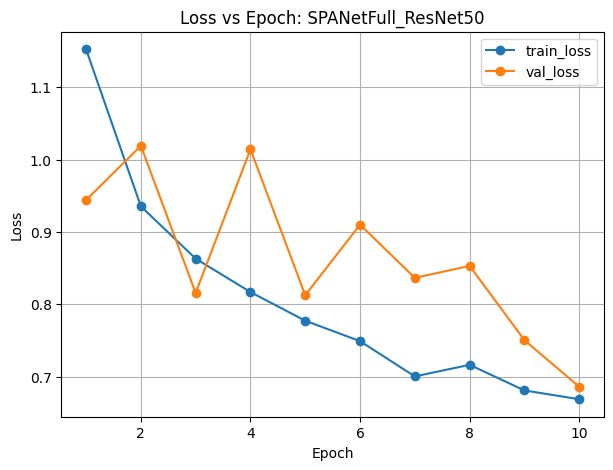

Best epoch: 10 | Best val_f1_macro: 0.8272


In [ ]:
epochs = [h["epoch"] for h in hist_spanet]
train_loss = [h["train_loss"] for h in hist_spanet]
val_loss = [h["val_loss"] for h in hist_spanet]

plt.figure(figsize=(7,5))
plt.plot(epochs, train_loss, marker="o", label="train_loss")
plt.plot(epochs, val_loss, marker="o", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch: SPANetFull_ResNet50")
plt.legend()
plt.grid(True)
plt.show()

print(
    f"Best epoch: {best_spanet['epoch']} | "
    f"Best val_f1_macro: {best_spanet['val_f1_macro']:.4f}"
)

**SPANetFull (ResNet50 backbone) Model RGB vs Ground Truth vs Prediction Visualization**

Loading checkpoint: /content/drive/MyDrive/ResearchProject (1)/model_results/SPANetFull_ResNet50_best.pt


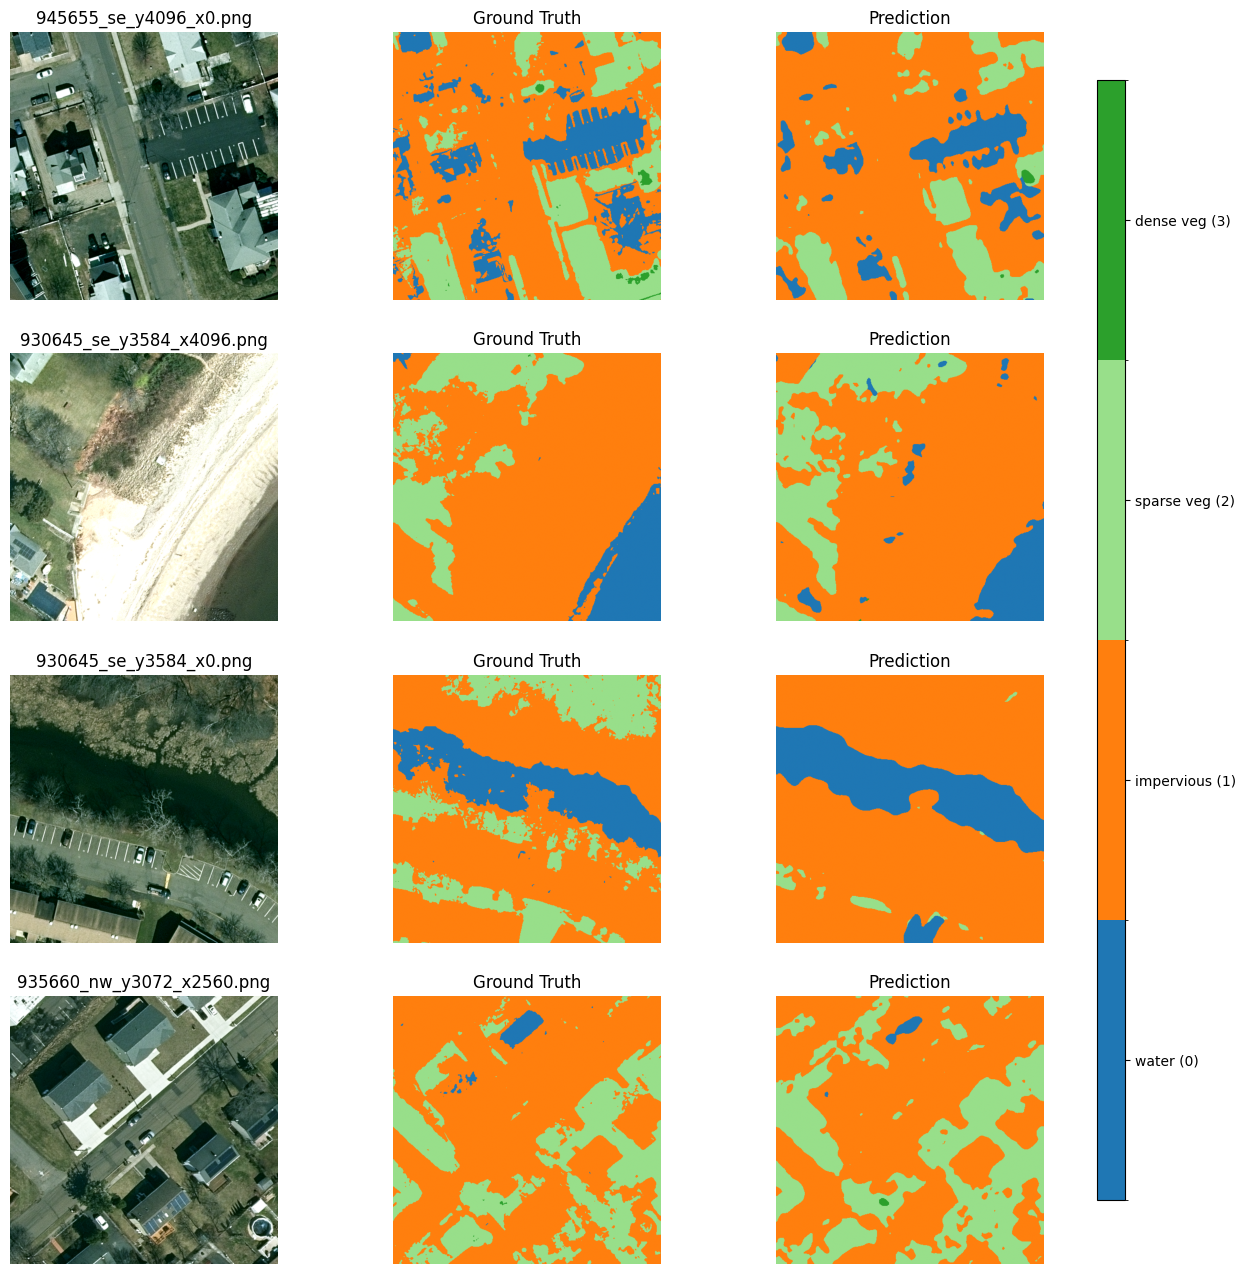

In [ ]:
# ---- paths ----
TILES_BASE = Path("/content/drive/MyDrive/ResearchProject (1)/dataset_tiles_512")
IMG_DIR = TILES_BASE / "images"
MSK_DIR = TILES_BASE / "masks"

# ---- reload model ----
model = SPANetFull(num_classes=4, pretrained_backbone=False).to(DEVICE)
ckpt_path = Path(best_spanet["path_ckpt"])
print("Loading checkpoint:", ckpt_path)
model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
model.eval()

# ---- colormap ----
class_colors = ["#1f77b4", "#ff7f0e", "#98df8a", "#2ca02c"]
cmap_mask = ListedColormap(class_colors)
norm_mask = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], ncolors=4)

fig, axes = plt.subplots(len(FIXED_TILES), 3, figsize=(14, 4*len(FIXED_TILES)))

for i, fname in enumerate(FIXED_TILES):
    img_fp = IMG_DIR / fname
    msk_fp = MSK_DIR / f"{Path(fname).stem}_mask.png"

    rgb = np.array(Image.open(img_fp).convert("RGB"), dtype=np.uint8)
    gt = np.array(Image.open(msk_fp), dtype=np.uint8)
    if gt.ndim == 3:
        gt = gt[:, :, 0]

    x = torch.from_numpy(rgb).permute(2, 0, 1).float().unsqueeze(0) / 255.0
    x = x.to(DEVICE)

    with torch.no_grad():
        logits = model(x)
        pred = torch.argmax(logits, dim=1).squeeze().cpu().numpy()

    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(fname)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(gt, cmap=cmap_mask, norm=norm_mask)
    axes[i, 1].set_title("Ground Truth")
    axes[i, 1].axis("off")

    im = axes[i, 2].imshow(pred, cmap=cmap_mask, norm=norm_mask)
    axes[i, 2].set_title("Prediction")
    axes[i, 2].axis("off")

# ---- single colorbar (right side) ----
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cax, ticks=[0,1,2,3])
cbar.set_ticklabels([
    "water (0)",
    "impervious (1)",
    "sparse veg (2)",
    "dense veg (3)"
])

plt.show()

**Comparison Table**

In [ ]:
RESULTS_DIR = Path("/content/drive/MyDrive/ResearchProject (1)/model_results")

MODELS = {
    "UNet": "FullUNet_23L_best_metrics.json",
    "DeepLabV3-ResNet50": "DeepLabV3_ResNet50_best_metrics.json",
    "UNet + SCSE": "UNet_SCSE_ResNet34_best_metrics.json",
    "SPANetFull": "SPANetFull_ResNet50_best_metrics.json",
}

rows = []

for model_name, fname in MODELS.items():
    path = RESULTS_DIR / fname
    with open(path, "r") as f:
        data = json.load(f)

    best = data["best"]

    row = {
        "Model": model_name,
        "Best Epoch": best["epoch"],
        "Mean F1 (macro)": best["val_f1_macro"],
        "Mean IoU (macro)": best["val_iou_macro"],
        "Pixel Accuracy": best["val_pixel_acc"],

        # Per-class F1
        "F1 Water": best["val_f1_per_class"][0],
        "F1 Impervious": best["val_f1_per_class"][1],
        "F1 Sparse Veg": best["val_f1_per_class"][2],
        "F1 Dense Veg": best["val_f1_per_class"][3],

        # Per-class Precision
        "Prec Water": best["val_prec_per_class"][0],
        "Prec Impervious": best["val_prec_per_class"][1],
        "Prec Sparse Veg": best["val_prec_per_class"][2],
        "Prec Dense Veg": best["val_prec_per_class"][3],

        # Per-class Recall
        "Recall Water": best["val_rec_per_class"][0],
        "Recall Impervious": best["val_rec_per_class"][1],
        "Recall Sparse Veg": best["val_rec_per_class"][2],
        "Recall Dense Veg": best["val_rec_per_class"][3],
    }

    rows.append(row)

df = pd.DataFrame(rows)

# Sort by Mean F1 (descending)
df = df.sort_values("Mean F1 (macro)", ascending=False)

df

Model  Best Epoch  Mean F1 (macro)  Mean IoU (macro)  \
3          SPANetFull          10         0.827186          0.718798   
1  DeepLabV3-ResNet50           7         0.810497          0.694303   
0                UNet           5         0.797415          0.681574   
2         UNet + SCSE          10         0.788502          0.666660   

   Pixel Accuracy  F1 Water  F1 Impervious  F1 Sparse Veg  F1 Dense Veg  \
3        0.883728  0.923105       0.898107       0.840071      0.647461   
1        0.867211  0.910242       0.886405       0.809164      0.636176   
0        0.870437  0.913799       0.892519       0.801705      0.581639   
2        0.862984  0.883206       0.888004       0.798296      0.584500   

   Prec Water  Prec Impervious  Prec Sparse Veg  Prec Dense Veg  Recall Water  \
3    0.944968         0.890592         0.844883        0.585841      0.902232   
1    0.949679         0.855322         0.853985        0.681282      0.873950   
0    0.966748         0.837396         0.907415        0.642562      0.866348   
2    0.976749         0.823296         0.916132        0.726364      0.806014   

   Recall Impervious  Recall Sparse Veg  Recall Dense Veg  
3           0.905749           0.835313          0.723568  
1           0.919833           0.768814          0.596672  
0           0.955411           0.718054          0.531268  
2           0.963750           0.707318          0.488996

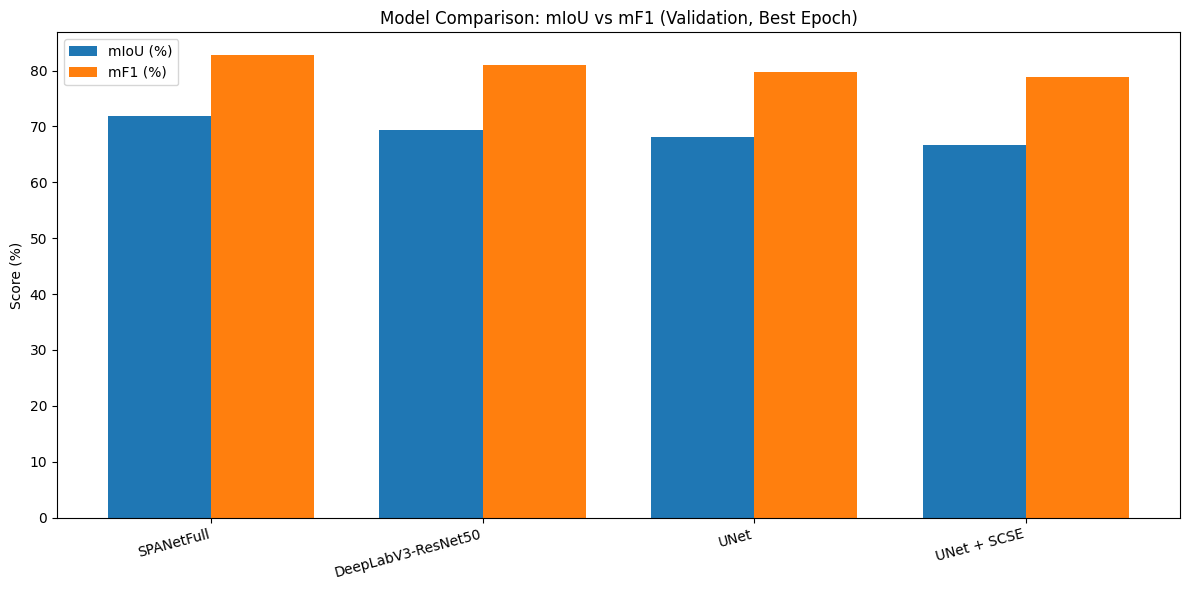

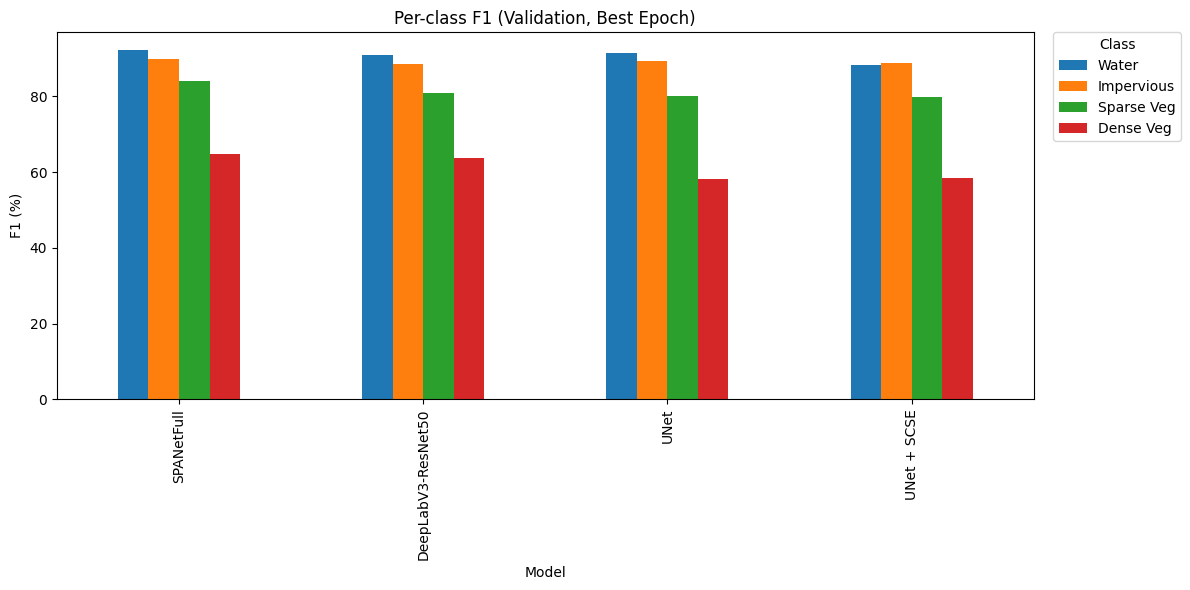

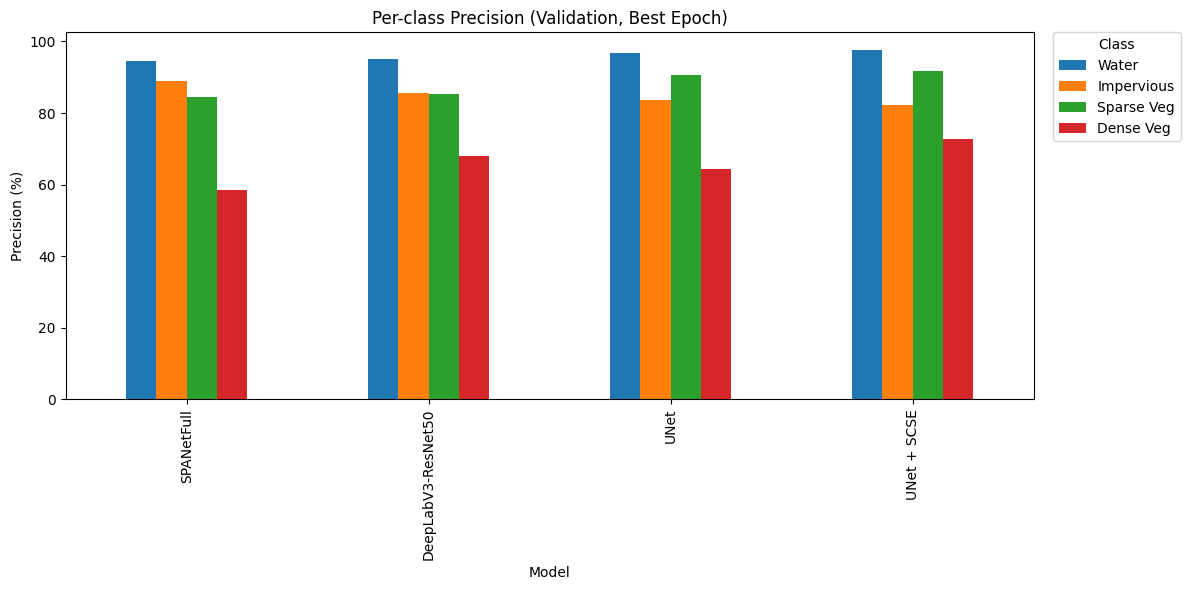

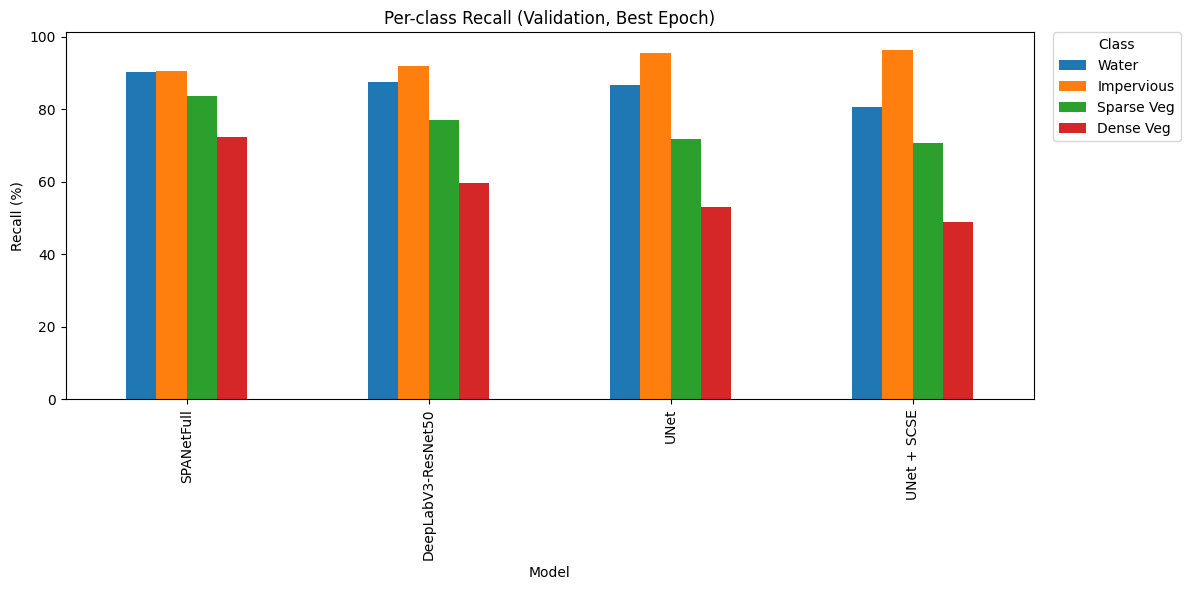

In [ ]:
# ----------------------------
# Expect df already exists from your "Comparison Table" cell
# Must contain:
#   "Model", "Mean F1 (macro)", "Mean IoU (macro)"
#   and per-class columns like:
#   F1 Water, F1 Impervious, F1 Sparse Veg, F1 Dense Veg
#   IoU Water, IoU Impervious, IoU Sparse Veg, IoU Dense Veg
#   Prec Water, Prec Impervious, Prec Sparse Veg, Prec Dense Veg
#   Recall Water, Recall Impervious, Recall Sparse Veg, Recall Dense Veg
# ----------------------------

CLASSES = ["Water", "Impervious", "Sparse Veg", "Dense Veg"]

# ---------- 1) Grouped bar: mIoU vs mF1 ----------
plot_df = df.copy()

# Convert to % for nicer chart (optional)
plot_df["mF1 (%)"]  = plot_df["Mean F1 (macro)"] * 100.0
plot_df["mIoU (%)"] = plot_df["Mean IoU (macro)"] * 100.0

x = np.arange(len(plot_df["Model"]))
w = 0.38

plt.figure(figsize=(12, 6))
plt.bar(x - w/2, plot_df["mIoU (%)"].values, width=w, label="mIoU (%)")
plt.bar(x + w/2, plot_df["mF1 (%)"].values,  width=w, label="mF1 (%)")
plt.xticks(x, plot_df["Model"].values, rotation=15, ha="right")
plt.ylabel("Score (%)")
plt.title("Model Comparison: mIoU vs mF1 (Validation, Best Epoch)")
plt.legend()
plt.tight_layout()
plt.show()


# ---------- Helper: make a wide per-class table from column prefix ----------
def wide_from_prefix(df_in: pd.DataFrame, prefix: str) -> pd.DataFrame:
    """
    Builds wide df with columns = CLASSES for a given metric prefix.
    Example prefix="F1" reads columns:
      F1 Water, F1 Impervious, F1 Sparse Veg, F1 Dense Veg
    """
    cols = [f"{prefix} {c}" for c in CLASSES]
    missing = [c for c in cols if c not in df_in.columns]
    if missing:
        raise KeyError(f"Missing columns for prefix '{prefix}': {missing}")

    wide = df_in[["Model"] + cols].copy()
    wide = wide.rename(columns={f"{prefix} {c}": c for c in CLASSES})
    wide = wide.set_index("Model")
    return wide.astype(float)


# ---------- 2) Per-class bar charts ----------
def plot_per_class(df_in: pd.DataFrame, prefix: str, title: str, ylabel: str, as_percent: bool = False):
    wide = wide_from_prefix(df_in, prefix)

    if as_percent:
        wide = wide * 100.0

    ax = wide.plot(kind="bar", figsize=(12, 6))
    ax.set_title(title)
    ax.set_ylabel(ylabel + (" (%)" if as_percent else ""))
    ax.set_xlabel("Model")
    ax.legend(title="Class", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    plt.show()

# F1 / IoU / Precision / Recall per class
plot_per_class(df, "F1",    "Per-class F1 (Validation, Best Epoch)",        "F1",        as_percent=True)
plot_per_class(df, "Prec",  "Per-class Precision (Validation, Best Epoch)", "Precision", as_percent=True)
plot_per_class(df, "Recall","Per-class Recall (Validation, Best Epoch)",    "Recall",    as_percent=True)
